<a href="https://colab.research.google.com/github/lugisz/lugisz.github.io/blob/main/The_Fed_Dual_Mandate_pypdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decoding The FED: Quantifying the "Dual Mandate"


**Research Question:** Does Chair Powell’s language reflect an equal balance between two mandates or has one mandate taken over the other?


Introduction <br><p>The Federal Reserve has a very important job in the United States economy. Congress gave the Fed two main goals. These goals are to create maximum employment and to keep prices stable. This is commonly known as the dual mandate. It is often difficult for the public to know which goal is more important to the Fed at any specific time. Sometimes the Fed focuses on helping people find jobs. At other times, the Fed focuses on stopping inflation.</br></p>

**The Problem** <br><p>Jerome Powell is the Chair of the Federal Reserve and he gives many speeches. These speeches explain the policy decisions of the central bank. However, there are dozens of speeches and they are very long. It is hard for an average person to read all of them to understand the main focus. We need a better way to see the big picture without reading every single word.</br></p>

**The Methodology** <br><p>This project uses data analysis to solve this problem. I collected 88 speeches by Jerome Powell from the years 2018 to 2024. I used Python to turn these speeches into data. I created two lists of keywords. The first list represents the employment mandate and includes words like labor and workers. The second list represents the price stability mandate and includes words like inflation and prices. I used a method called TFIDF to calculate the weight of these words in every speech.</br></p>

**The Goal** <br><p>The result of this project is a visual timeline. This timeline shows us exactly when Jerome Powell changed his mind. I expect to see that he talked more about jobs during the pandemic. I also expect to see a big shift to inflation words starting in late 2021. This project helps us quantify the dual mandate and understand the changing priorities of the Federal Reserve.</br></p>

In [51]:
!pip install nltk==3.9.2
!pip install pypdf

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import os

FOLDER_NAME = "powell_speeches"

# Build the full path
DRIVE_ROOT = "/content/drive/MyDrive/Colab Notebooks/Python_Text-Analysis"
path = os.path.join(DRIVE_ROOT, FOLDER_NAME)

# Create the folder if it doesn’t exist
os.makedirs(path, exist_ok=True)

print(f"✅ Folder ready at: {path}")

✅ Folder ready at: /content/drive/MyDrive/Colab Notebooks/Python_Text-Analysis/powell_speeches


In [65]:
import re
import pandas as pd
from pypdf import PdfReader
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, LatentDirichletAllocation
from wordcloud import WordCloud
import numpy as np


pdf_folder = path
text_data = []

filename_date_pattern = re.compile(r"(\d{8})")

for filename in os.listdir(pdf_folder):
    if filename.endswith(".pdf"):
        filepath = os.path.join(pdf_folder, filename)

        try:
            reader = PdfReader(filepath)
            full_text = ""
            for page in reader.pages:
                full_text += page.extract_text()

            match = filename_date_pattern.search(filename)
            extracted_date = match.group(1) if match else None

            text_data.append({
                "filename": filename,
                "date": extracted_date,
                "text": full_text
            })

        except Exception as e:
            print(f"Could not read {filename}: {e}")

df_powell = pd.DataFrame(text_data)


df_powell['date'] = pd.to_datetime(df_powell['date'], format='%Y%m%d', errors='coerce')
df_powell['date_string'] = df_powell['date'].dt.strftime('%Y-%m-%d')
df_powell = df_powell.sort_values('date')

print(f"Successfully converted {len(df_powell)} speeches to a DataFrame.")
df_powell.head()

Successfully converted 88 speeches to a DataFrame.


,filename,date,text,date_string
54,powell20180205.pdf,2018-02-05,Federal Reserve Chairman Powell Transcript Fe...,2018-02-05
55,powell20180213.pdf,2018-02-13,For release on delivery \n10:00 a.m. EST \nFe...,2018-02-13
56,powell20180227.pdf,2018-02-27,For release on delivery \n8:30 a.m. EST \nFebr...,2018-02-27
57,powell20180406.pdf,2018-04-06,For release on delivery \n1:30 p.m. EDT (12:30...,2018-04-06
58,powell20180508.pdf,2018-05-08,For release on delivery \n3:15 a.m. EDT (9:15 ...,2018-05-08


In [55]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [66]:
EN_STOP = set(stopwords.words('english'))
print("English stopwords:", EN_STOP)
CUSTOM_STOP = {
    'new','likely','bank','banks','commitee', 'fomc', 'board', 'new', 'https','since','applause', 'cheers', 'government', 'percent', 'policy', 'chair', 'reserves', 'also', 'data', 'many', 'powell', 'fed', 'nation', 'nations', 'must', 'upon', 'shall', 'may', 'would', 'well', 'see', 'text', 'country', 'people', 'states', 'year', 'years', 'united', 'american','great', 'every', 'reserve', 'federal', 'america'
}
STOPWORDS = EN_STOP.union(CUSTOM_STOP)

def simple_clean_tokens(text):
    text = text.lower()
    tokens = word_tokenize(text)
    clean = [tok for tok in tokens if tok.isalpha() and len(tok) >= 3 and tok not in STOPWORDS]
    return clean

df_powell['tokens'] = df_powell['text'].apply(simple_clean_tokens);
df_powell['text_clean'] = df_powell['tokens'].apply(lambda toks: " ".join(toks))

print("Sample tokens:", df_powell.loc[0, 'tokens'][:25])
df_powell[['filename','date', 'date_string','text', 'text_clean']].head().reset_index()

English stopwords: {"it'd", "isn't", 'where', 'wouldn', 'with', "i'll", 'below', 'through', 'above', 'can', 'your', 'her', 'will', "you're", 'o', 'being', 'whom', 'hadn', 'me', "i'd", "we'd", 'any', 'few', "mustn't", 'do', 'not', 'ma', "shan't", 'then', 're', 'don', 'myself', 'they', 'by', 'just', "mightn't", 'than', 'should', "you'll", 'of', 'shouldn', 's', 'ain', 'up', 'only', 'once', 'has', "don't", "should've", 'd', 'herself', 'same', 'hers', 'during', 'himself', 'hasn', 'before', "he'd", 'an', 'down', 'again', 'its', 'off', 'why', 'how', "she'd", 'having', 'both', 'more', 'over', 'doesn', "doesn't", 'she', 'until', 'aren', 'so', 'mustn', 'at', "she'll", 've', "they're", 'haven', 'no', "it's", 'you', 'itself', 'had', 'these', 'ours', "he'll", 'been', 'is', 'needn', 'some', "we'll", "weren't", 'i', 't', 'such', "wasn't", 'did', 'for', 'doing', 'in', 'have', 'as', "i've", "shouldn't", 'if', 'those', 'we', 'to', 'after', "it'll", 'their', 'ourselves', 'very', 'theirs', 'was', 'weren',

,index,filename,date,date_string,text,text_clean
0,54,powell20180205.pdf,2018-02-05,2018-02-05,Federal Reserve Chairman Powell Transcript Fe...,chairman transcript february chairman hello ja...
1,55,powell20180213.pdf,2018-02-13,2018-02-13,For release on delivery \n10:00 a.m. EST \nFe...,release delivery est february remarks jerome c...
2,56,powell20180227.pdf,2018-02-27,2018-02-27,For release on delivery \n8:30 a.m. EST \nFebr...,release delivery est february statement jerome...
3,57,powell20180406.pdf,2018-04-06,2018-04-06,For release on delivery \n1:30 p.m. EDT (12:30...,release delivery edt cdt april outlook economy...
4,58,powell20180508.pdf,2018-05-08,2018-05-08,For release on delivery \n3:15 a.m. EDT (9:15 ...,release delivery edt local time monetary influ...


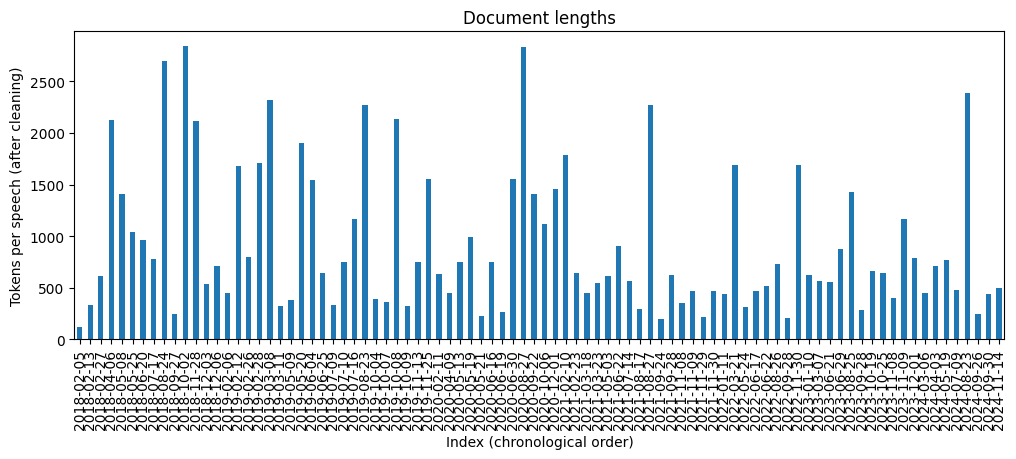

,term,count
0,inflation,1294
1,monetary,706
2,economic,686
3,economy,608
4,market,602
5,labor,595
6,rate,576
7,financial,530
8,growth,441
9,system,370


In [67]:
# Document lengths
df_powell['n_tokens'] = df_powell['tokens'].apply(len)
ax = df_powell.plot(x='date_string', y='n_tokens', kind='bar', figsize=(12,4), legend=False)
ax.set_ylabel("Tokens per speech (after cleaning)")
ax.set_xlabel("Index (chronological order)")
ax.set_title("Document lengths")
plt.show()

# Global top terms
all_terms = [t for toks in df_powell['tokens'] for t in toks]
top20 = Counter(all_terms).most_common(20)
pd.DataFrame(top20, columns=['term','count'])

Top 50 most frequent words across all speeches:

inflation       1294
monetary        706
economic        686
economy         608
market          602
labor           595
rate            576
financial       530
growth          441
system          370
unemployment    367
time            304
employment      295
strong          266
stability       258
job             254
support         250
rates           234
governors       225
price           224
figure          223
business        221
conditions      216
committee       213
credit          210
past            208
interest        205
outlook         203
low             202
businesses      200
recent          196
public          192
pandemic        190
current         188
today           186
central         185
force           174
risks           171
important       169
much            169
crisis          166
expectations    166
prices          165
work            165
continue        160
funds           158
high            156
level     

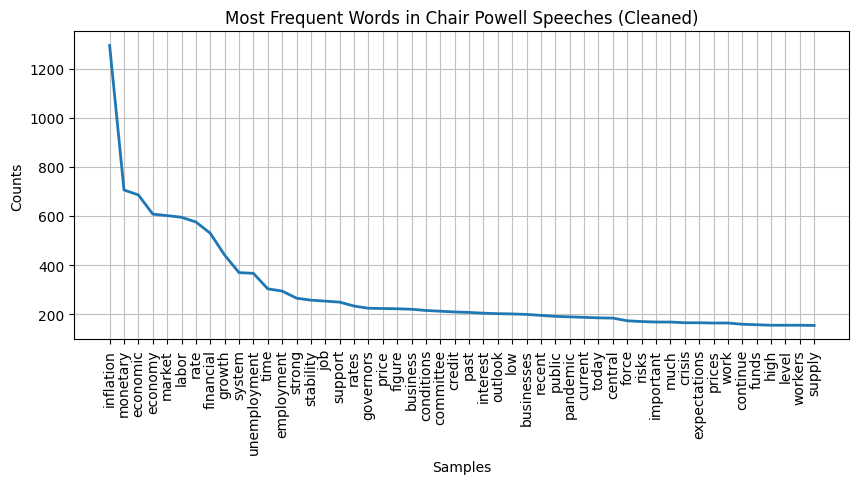

In [80]:
all_tokens = [t for toks in df_powell['tokens'] for t in toks]
fdist = FreqDist(all_tokens)

print("Top 50 most frequent words across all speeches:\n")
for word, freq in fdist.most_common(50):
    print(f"{word:15s} {freq}")


plt.figure(figsize=(10,4))
fdist.plot(50, cumulative=False)
plt.title("Most Frequent Words in Chair Powell Speeches (Cleaned)")
plt.show()

In [59]:

# convert a collection of text documents (your speeches) into a matrix where: Each row = one document (a speech);
# Each column = one term (a word);
# Each cell value = TF–IDF weight of that term in that document
# min_df=2 → ignore words that appear in fewer than 2 documents
tfidf = TfidfVectorizer(min_df=2)

# Feeds your cleaned text (from the text_clean column) into the vectorizer.
# Two steps happen in one command:
# .fit() — learns the vocabulary and IDF (Inverse Document Frequency) weights.
# .transform() — applies the TF–IDF transformation to each document.
# Returns a sparse matrix X_tfidf of shape:

X_tfidf = tfidf.fit_transform(df_powell['text_clean'])

# Retrieves the list of all terms (vocabulary) that the vectorizer kept.
# Converts it into a NumPy array for easy indexing and sorting later.
# You’ll use it when finding the top TF–IDF terms for each speech:

terms = np.array(tfidf.get_feature_names_out())

# ((# of docs, # of unique words), # of unique words)
X_tfidf.shape, len(terms)


((88, 4281), 4281)

In [68]:

def top_tfidf_terms_for_doc(doc_idx, top_n=8): #Define a function that returns the top-n TF–IDF terms for a single document (speech).
    row = X_tfidf.getrow(doc_idx).toarray().ravel() #row is a vector of TF–IDF scores for one speech, where each position corresponds to one word in terms
    top_idx = row.argsort()[::-1][:top_n] #top_idx = positions of the most distinctive words in this speech.
    # terms[top_idx] gets the actual word strings for those indices.
    # row[top_idx] gets their corresponding TF–IDF scores.
    # zip(...) pairs each word with its score.
    # list(...) turns that into a list of (word, score) tuples.
    return list(zip(terms[top_idx], row[top_idx]))

# Show a few speeches (early, middle, recent)
# This loop picks three speeches: The first (i = 0), The middle one (len(df)//2), The last one (len(df)-1)
for i in [0, len(df_powell)//2, len(df_powell)-1]:
    print(f"\n=== {df_powell.loc[i, 'date_string']} ===") #Prints a header showing which speech you’re examining
    for term, score in top_tfidf_terms_for_doc(i, top_n=8): #Calls the function to get the top 12 terms for that document
        print(f"{term:15s} {score:.3f}")



=== 2020-02-11 ===
integrity       0.299
decisions       0.209
chairman        0.209
financial       0.173
oath            0.160
hello           0.160
jay             0.160
tasked          0.160

=== 2023-11-09 ===
recovery        0.154
economic        0.152
labor           0.138
economy         0.138
support         0.134
fiscal          0.125
pandemic        0.123
layoffs         0.123

=== 2019-11-25 ===
inflation       0.324
labor           0.191
dallas          0.171
economy         0.171
market          0.144
progress        0.132
restraint       0.129
rate            0.124


In [69]:
sim = cosine_similarity(X_tfidf) #Computes a cosine similarity matrix for all speeches
target = len(df_powell) - 1  # Chooses the most recent speech (the last row in your DataFrame) as the target document.
pairs = [(i, sim[target, i]) for i in range(len(df_powell)) if i != target] #Builds a list of tuples for every other speech, skips the target one
pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)[:5] #Sorts the list of (index, similarity) pairs by similarity score in descending order

print(f"Most similar to {df_powell.loc[target,'date_string']}:")
for idx, score in pairs_sorted: #Iterates over the top-5 most similar speeches
    print(f"  {df_powell.loc[idx,'date_string']} (cosine={score:.3f})")

# Cosine similarity treats each speech as a high-dimensional vector (words as axes).
# The closer the angle between two vectors, the more similar their language use — even if the speeches differ in length.

Most similar to 2019-11-25:
  2019-11-13 (cosine=0.606)
  2019-07-16 (cosine=0.538)
  2019-10-07 (cosine=0.537)
  2019-03-11 (cosine=0.456)
  2019-02-26 (cosine=0.448)


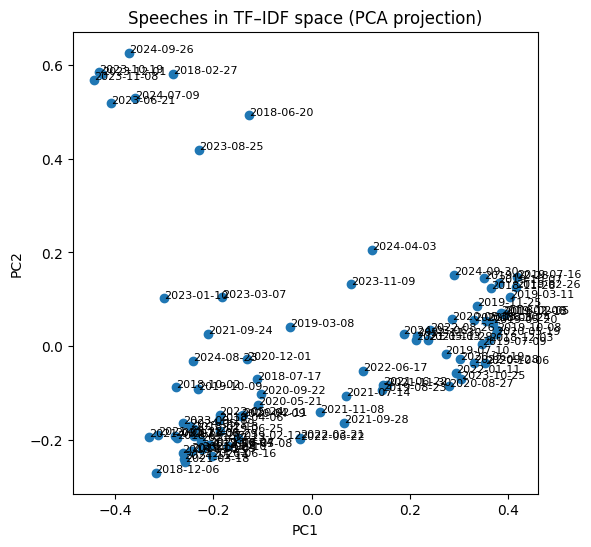

In [70]:
# 2D projection (small corpus → OK to densify)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_tfidf.toarray())
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1])
for i, row in df_powell.iterrows():
    ax.annotate(str(row['date_string']), (coords[i,0], coords[i,1]), fontsize=8)
ax.set_title("Speeches in TF–IDF space (PCA projection)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.show()


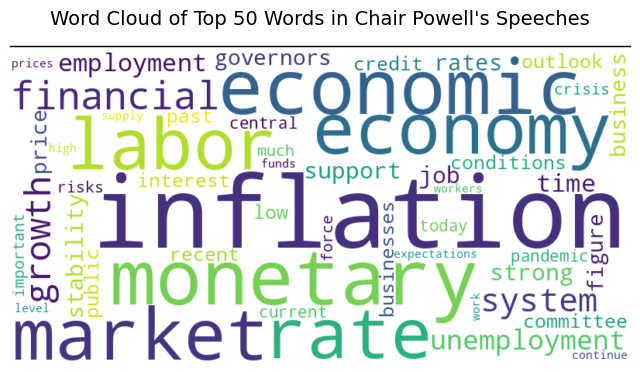

In [71]:
word_freq = dict(fdist.most_common(50))

# Generate Word Cloud
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(word_freq)

# Plot with Subplots (Defining 'ax' properly)
fig, ax = plt.subplots(figsize=(8, 6))

# Display Image
ax.imshow(wc, interpolation='bilinear')
ax.axis("off")

# Add Line Separator
ax.plot([0, 1], [1.02, 1.02], transform=ax.transAxes, color='black', linewidth=1, clip_on=False)

# Add Title
plt.title("Word Cloud of Top 50 Words in Chair Powell's Speeches", fontsize=14, pad=20)

plt.show()

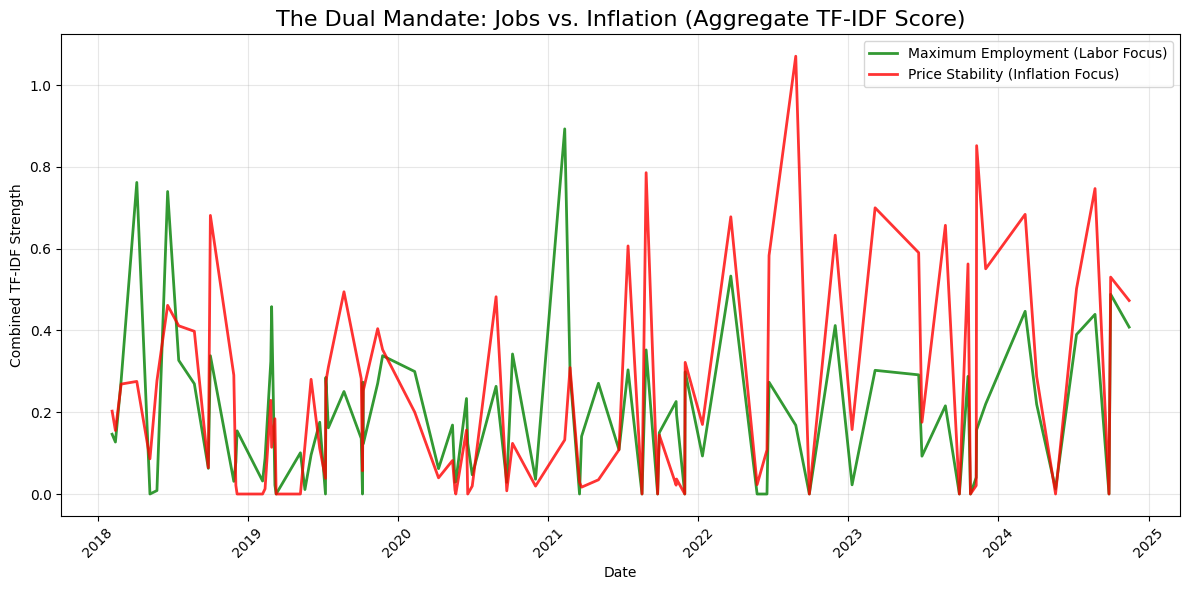

In [82]:
# 1. Define the two "teams" of words
employment_terms = ["labor", "unemployment", "employment", "job", "workers"]
stability_terms = ["inflation", "stability", "price", "expectations", "supply"]

# 2. Sum the TF-IDF scores for each group to create an "Index"
# We loop through the terms, find their column in X_tfidf, and sum them up
df_powell['employment_score'] = 0
df_powell['stability_score'] = 0

for term in employment_terms:
    if term in terms:
        term_idx = np.where(terms == term)[0][0]
        df_powell['employment_score'] += X_tfidf[:, term_idx].toarray().ravel()

for term in stability_terms:
    if term in terms:
        term_idx = np.where(terms == term)[0][0]
        df_powell['stability_score'] += X_tfidf[:, term_idx].toarray().ravel()

# 3. Plot the Battle of the Mandates
plt.figure(figsize=(12, 6))

plt.plot(df_powell['date'], df_powell['employment_score'],
         label="Maximum Employment (Labor Focus)", color='green', linewidth=2, alpha=0.8)

plt.plot(df_powell['date'], df_powell['stability_score'],
         label="Price Stability (Inflation Focus)", color='red', linewidth=2, alpha=0.8)

plt.title("The Dual Mandate: Jobs vs. Inflation (Aggregate TF-IDF Score)", fontsize=16)
plt.ylabel("Combined TF-IDF Strength")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()